In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import seaborn as sns
import torch
import pandas as pd
from loguru import logger
from omegaconf import OmegaConf
from tqdm import tqdm

from rocketshp import config
from rocketshp.data.atlas import ATLASDataModule
from rocketshp.modeling.architectures import RocketSHPModel
from rocketshp.plot import display_trajectory

plt.rcParams.update({
    "axes.prop_cycle": "cycler('color', ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9'])",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 16,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
    "svg.fonttype": "none",
    })

In [2]:
# config_file = "../configs/default_config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=07-train_loss=2.66.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_sqformer/model-epoch=15-train_loss=13.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss/model-epoch=02-train_loss=0.83.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss.2/model-epoch=17-train_loss=0.28.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/retesting_old/model-epoch=02-train_loss=0.69.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha3/model-epoch=05-train_loss=1.03.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha5/model-epoch=05-train_loss=1.00.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/grad_norm_alpha0.12_lr1e-5/model-epoch=19-train_loss=0.55.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/seq_feats_only/model-epoch=18-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/atlas_prequantized/model-epoch=03-train_loss=0.70.pt.ckpt"

# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp_2/model-epoch=16-train_loss=0.30.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/new_predictions_local/model-epoch=05-val_loss=10.18.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_0/model-epoch=18-val_loss=2.78.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl/model-epoch=00-val_loss=36.86.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl/model-epoch=02-val_loss=37.17.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl_reweighted/model-epoch=11-val_loss=35.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/test_kl/model-epoch=01-val_loss=2.18.pt.ckpt"

config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/rocketshp_pretrained_20250215_v0.yml"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/huggingface/checkpoints/rocketshp_pretrained_20250215_v0.ckpt"  # *****

# config_file = "/mnt/home/ssledzieski/Projects/rocketshp/configs/seqonly_config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/fs_shp_pred_kl_seqonly/model-epoch=30-val_loss=2.18.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
adl = ATLASDataModule(
    config.PROCESSED_DATA_DIR / "atlas/atlas_processed.h5",
    seq_features=True,
    struct_features=True,
    batch_size=8,
    num_workers=PARAMS.num_data_workers,
    train_pct=PARAMS.train_pct,
    val_pct=PARAMS.val_pct,
    random_seed=PARAMS.random_seed,
    struct_stage=PARAMS.struct_stage,
)
adl.setup("train")
ads = adl.dataset
logger.info(
    f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}"
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/s

2025-04-07 11:49:47.676 | INFO     | __main__:<module>:14 - 4167, 3360, 396, 411


In [5]:
# model = RocketSHPModel.load_from_checkpoint("latest")
model = RocketSHPModel.load_from_checkpoint(checkpoint_file, strict=True)
model = model.to(device)
model = model.eval()

In [31]:
from scipy.stats import pearsonr, spearmanr

### by key ###


def get_idx_name(name):
    return adl.dataset.samples.index(name)


# key = "1tzw_A/R2"
# feats, labels = adl.dataset[get_idx_name(key)]
##############

### by index ###
# DATA_SUBSET = adl.test_data
DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data

# SAMPLE_I = 35
# SAMPLE_I = 70 #*** 1TZW
# SAMPLE_I = 15 # validation
# SAMPLE_I = 84 # validation
# SAMPLE_I = 100 # validation
# SAMPLE_I = 192 # validation
# SAMPLE_I = 300 # validation
SAMPLE_I = 392

feats, labels = DATA_SUBSET[SAMPLE_I]
key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
##############

pdb_code, rep = key.split("/")
pdb_code_save = pdb_code + "_seqOnly"
logger.info(f"Key: {key}")
logger.info(f"Sequence length: {len(labels['rmsf'])}")

def normalize(x):
    return (x - x.mean()) / x.std()


with torch.no_grad():
    both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})
    # feats["struct_feats"] = torch.zeros_like(feats["struct_feats"])
    # seqonly_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})

2025-04-07 11:54:55.931 | INFO     | __main__:<module>:34 - Key: 7ned_A/R3
2025-04-07 11:54:55.932 | INFO     | __main__:<module>:35 - Sequence length: 546


In [32]:
dyna1_path = f"/mnt/home/ssledzieski/GitHub/Dyna-1/rshp_results/{pdb_code}/{pdb_code}-Dyna1.csv"
dyna1_df = pd.read_csv(dyna1_path)
dyna1_result = dyna1_df.iloc[:, 2].values
sequence = "".join(dyna1_df.iloc[:, 1].values)
# logger.info(sequence)

In [33]:
from rocketshp.trajectory import compute_rmsf
bioemu_path = f"/mnt/home/ssledzieski/GitHub/bioemu/rshp_results/{pdb_code}_10"
bioemu_traj = md.load(f"{bioemu_path}/samples.xtc", top=f"{bioemu_path}/topology.pdb")
bioemu_rmsf = compute_rmsf(bioemu_traj)

# bioemu_path = f"/mnt/home/ssledzieski/GitHub/bioemu/rshp_results/{pdb_code}_100"
# bioemu_traj = md.load(f"{bioemu_path}/samples.xtc", top=f"{bioemu_path}/topology.pdb")
# bioemu_rmsf_100 = compute_rmsf(bioemu_traj)

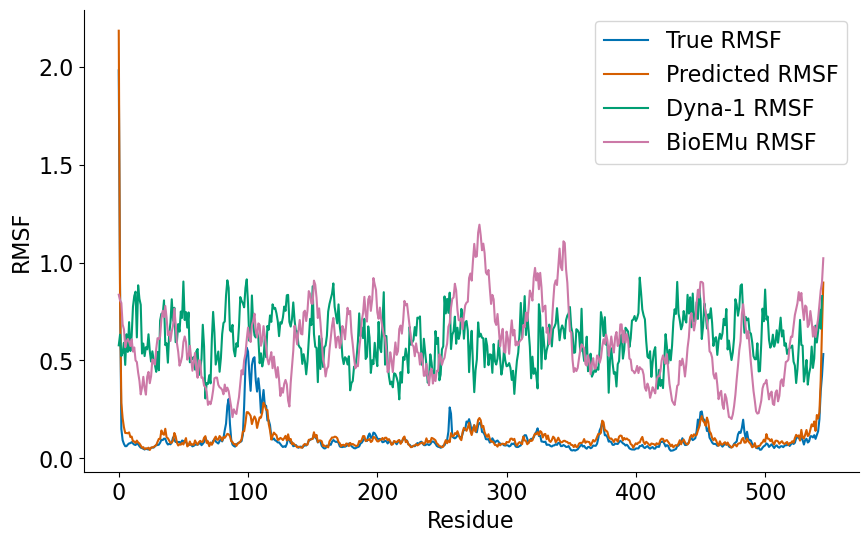

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(labels["rmsf"], label="True RMSF")
plt.plot(both_result["rmsf"].detach().cpu().numpy().squeeze(), label="Predicted RMSF")
plt.plot(dyna1_result, label="Dyna-1 RMSF")
plt.plot(bioemu_rmsf, label="BioEMu RMSF")
# plt.plot(bioemu_rmsf_100, label="BioEMu RMSF 100")
plt.ylabel("RMSF")
plt.xlabel("Residue")
# plt.title(f"Protein: {key}")
plt.legend()
# plt.savefig( 
    # config.FIGURES_DIR / f"{pdb_code_save}_rmsf_comparison.svg",
# )
plt.show()

In [37]:
spearman = spearmanr(
    labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze()
)
pearson = pearsonr(labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze())
mse = (
    (labels["rmsf"] - both_result["rmsf"].detach().cpu().numpy().squeeze()) ** 2
).mean()

logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

2025-04-07 12:16:37.419 | INFO     | __main__:<module>:9 - Protein: 7ned_A/R3
2025-04-07 12:16:37.420 | INFO     | __main__:<module>:10 - Spearman: SignificanceResult(statistic=0.762674224288031, pvalue=5.0541215909579466e-105)
2025-04-07 12:16:37.421 | INFO     | __main__:<module>:11 - Pearson: PearsonRResult(statistic=0.8954599, pvalue=2.317566237059778e-193)
2025-04-07 12:16:37.422 | INFO     | __main__:<module>:12 - MSE: 0.0026410853024572134


In [38]:
logger.info(str(config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc"))
logger.info(str(config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb"))
traj = md.load_xtc(
    config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=config.RAW_DATA_DIR / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb",
)
# view = display_trajectory(traj)
view = display_trajectory(
    traj,
    bfactor=both_result["rmsf"].detach().cpu().numpy().squeeze(),
    coloring="bfactor",
    normalize=True,
    RMAX=0.3,
)
# view = display_trajectory(traj[::10], bfactor=labels["rmsf"].squeeze(), coloring="bfactor", normalize=True, RMAX=0.3)
# view = display_trajectory(traj[::100], coloring="residueindex")
view

2025-04-07 12:16:40.903 | INFO     | __main__:<module>:1 - /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/7n/7ned_A_prod_R3_fit.xtc
2025-04-07 12:16:40.905 | INFO     | __main__:<module>:2 - /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/7n/7ned_A.pdb


NGLWidget(max_frame=10000)

In [12]:
# from itertools import combinations
# from rocketshp.trajectory import compute_autocorrelation, compute_contacts
# from statsmodels.tsa.stattools import acf
# import numpy as np
# n_lags = 20
# correlations = np.zeros((ctc.shape[1], ctc.shape[1], n_lags))
# for (c_i, c_j) in tqdm(combinations(range(ctc.shape[1]),2)):
#         corrs_ = acf(ctc[:,c_i,c_j], nlags=ctc.shape[0]-1, fft=True)
#         for lag in np.arange(n_lags):
#             correlations[c_i, c_j, lag] = corrs_[lag]
#             correlations[c_j, c_i, lag] = corrs_[lag]

# for l in np.arange(n_lags):
#     plt.figure()
#     sns.heatmap(1 - correlations[:,:,l], cmap="coolwarm", center=0)
#     plt.title(f"Contact autocorrelation at lag {l}")
#     plt.show()

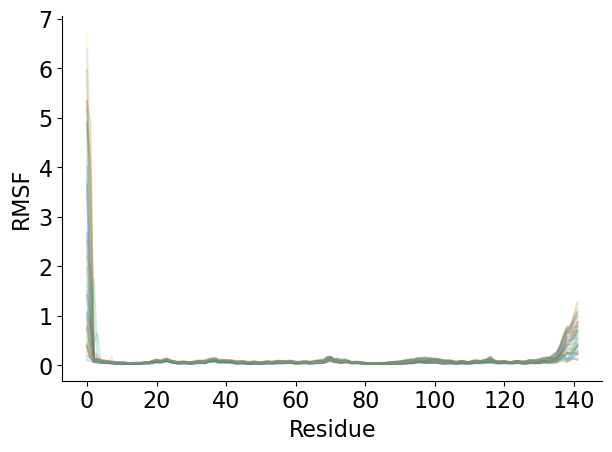

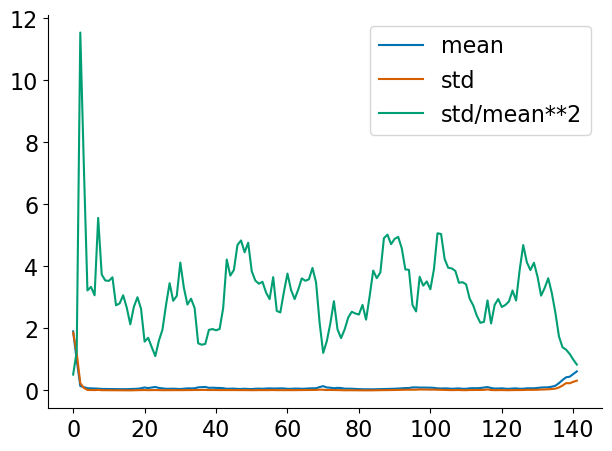

In [41]:
import numpy as np

subsample_rmsf = []
for _ in range(50):
    start = np.random.randint(0, traj.n_frames // 2)
    duration = np.random.randint(1, traj.n_frames // 2 - start)
    stride = 1
    t_sub = traj[start : start + duration : stride]
    sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
    subsample_rmsf.append(sample)

subsample_rmsf = np.stack(subsample_rmsf)
import matplotlib.pyplot as plt

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
plt.xlabel("Residue")
plt.ylabel("RMSF")
plt.show()

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0), label="mean")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0), label="std")
plt.plot(
    np.arange(subsample_rmsf.shape[1]),
    subsample_rmsf.std(axis=0) / (subsample_rmsf.mean(axis=0) ** 2),
    label="std/mean**2",
)

plt.legend()
plt.show()

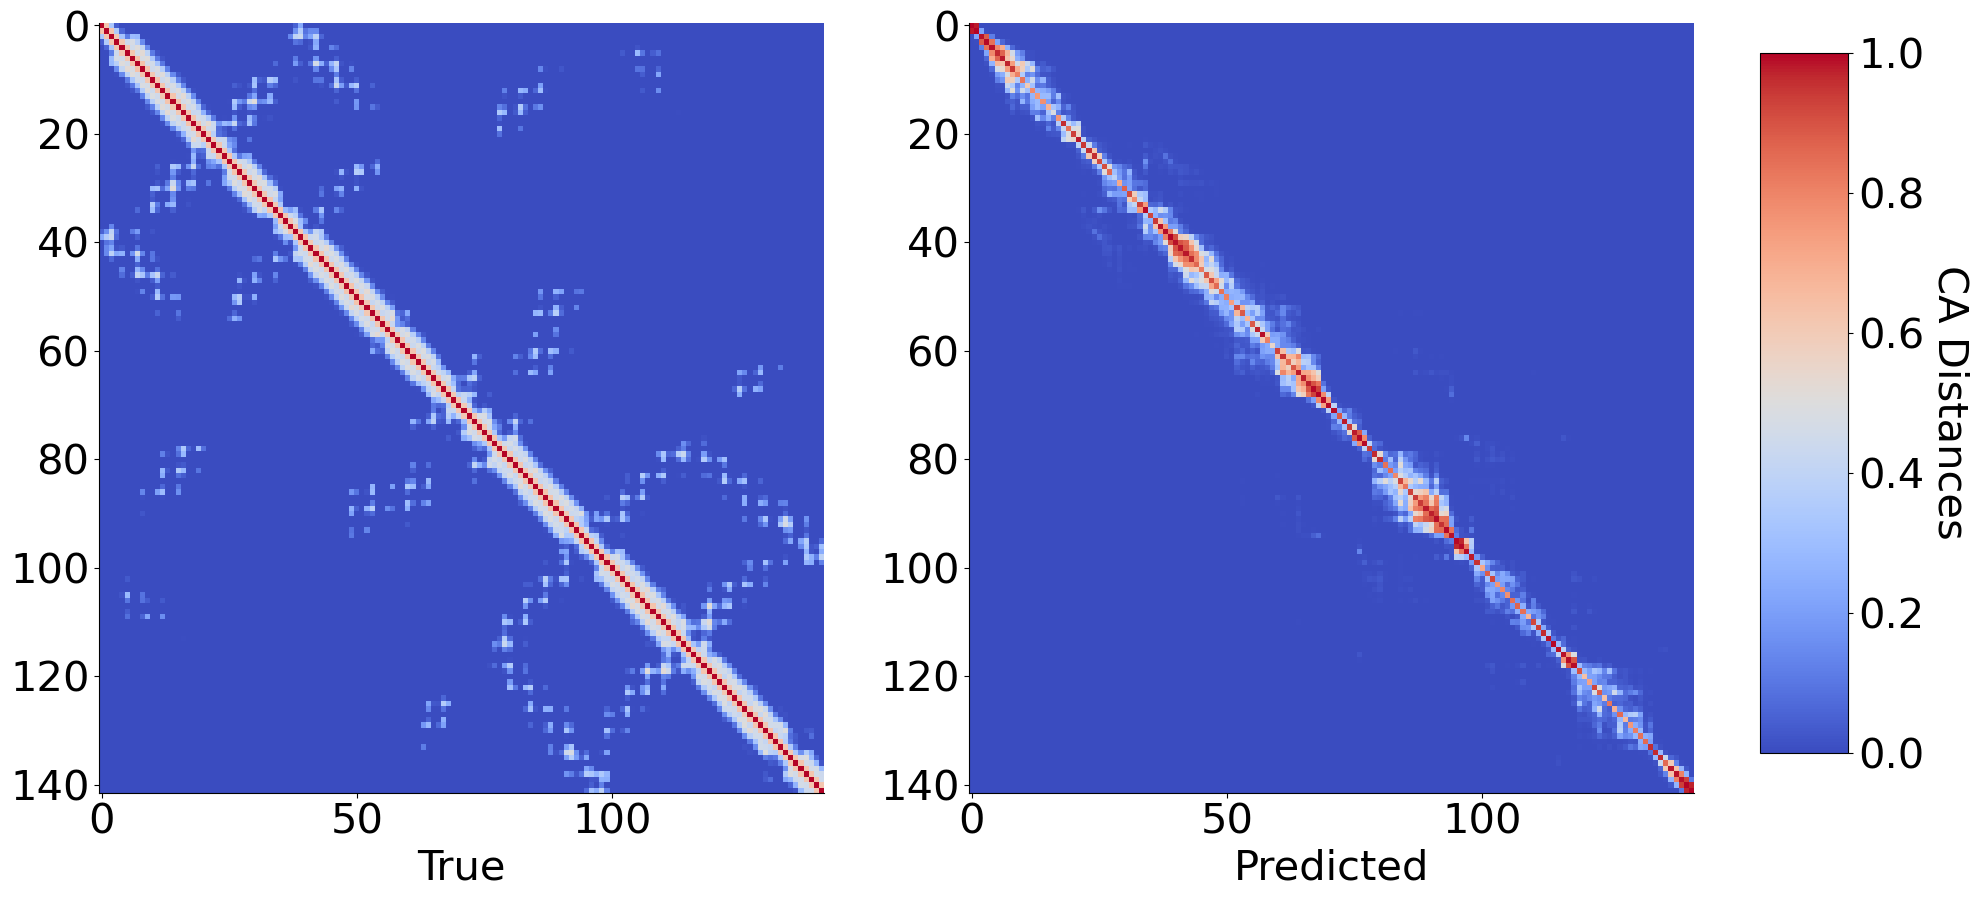

In [ ]:
# Autocorrelation
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
squared_label_type = "ca_dist"

true_sqform = labels[squared_label_type].squeeze().T
predicted_sqform = both_result[squared_label_type].cpu().squeeze().T

# increase font size
with plt.rc_context({"font.size": 30}):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    im1 = axes[0].imshow(1 - true_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm")
    axes[0].set_xlabel("True")
    im2 = axes[1].imshow(
        1 - predicted_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm"
    )
    axes[1].set_xlabel("Predicted")

    # add space for colour bar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.set_ylabel("CA Distances", rotation=-90, va="bottom")

    # plt.savefig(
    # config.FIGURES_DIR / f"{pdb_code_save}_ca_dist_comparison.svg",
    # bbox_inches="tight",
    # )
    plt.show()

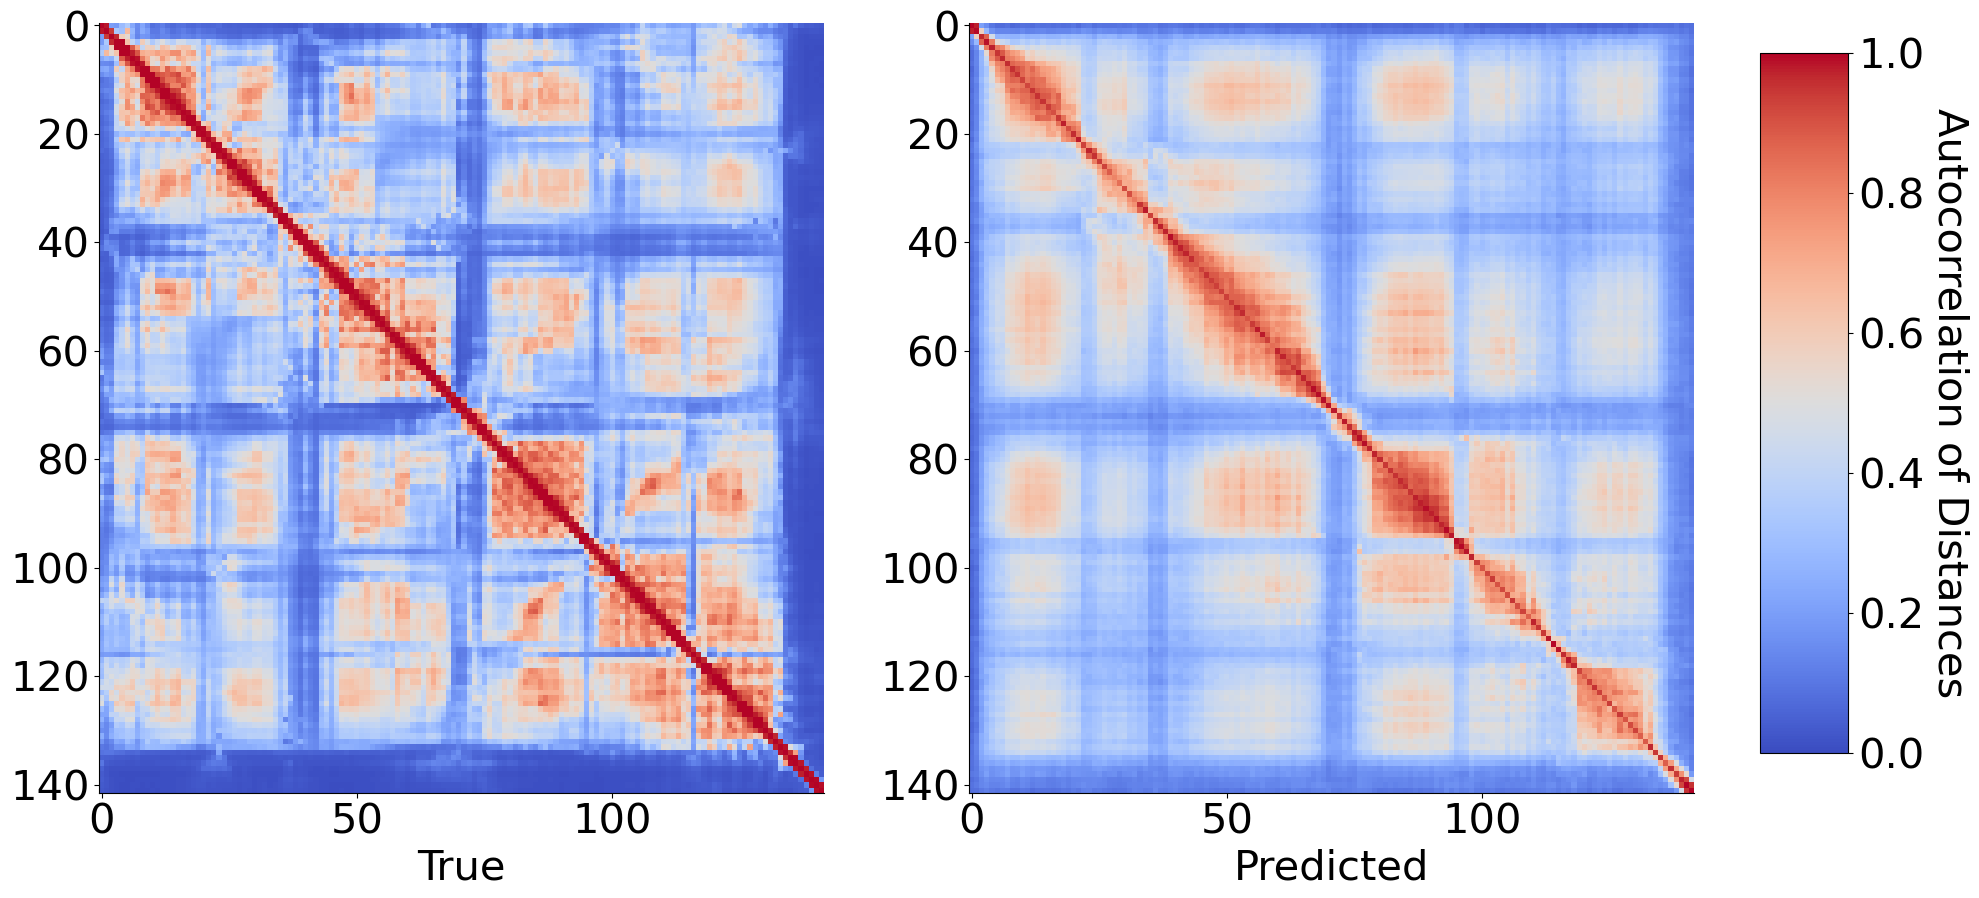

In [ ]:
# Autocorrelation
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
squared_label_type = "autocorr"

true_sqform = labels[squared_label_type].squeeze().T
predicted_sqform = both_result[squared_label_type].cpu().squeeze().T

# ax[0].imshow(true_sqform)
#
# image = ax[1].imshow(predicted_sqform)
# ax[1].set_xlabel("Predicted")
# plt.colorbar(image)

# increase font size
with plt.rc_context({"font.size": 30}):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    im1 = axes[0].imshow(1 - true_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm")
    axes[0].set_xlabel("True")
    im2 = axes[1].imshow(
        1 - predicted_sqform, vmin=0, vmax=1, aspect="auto", cmap="coolwarm"
    )
    axes[1].set_xlabel("Predicted")

    # add space for colour bar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.set_ylabel("Autocorrelation of Distances", rotation=-90, va="bottom")

    plt.savefig(
        config.FIGURES_DIR / f"{pdb_code_save}_autocorr_comparison.svg",
        bbox_inches="tight",
    )
    plt.show()

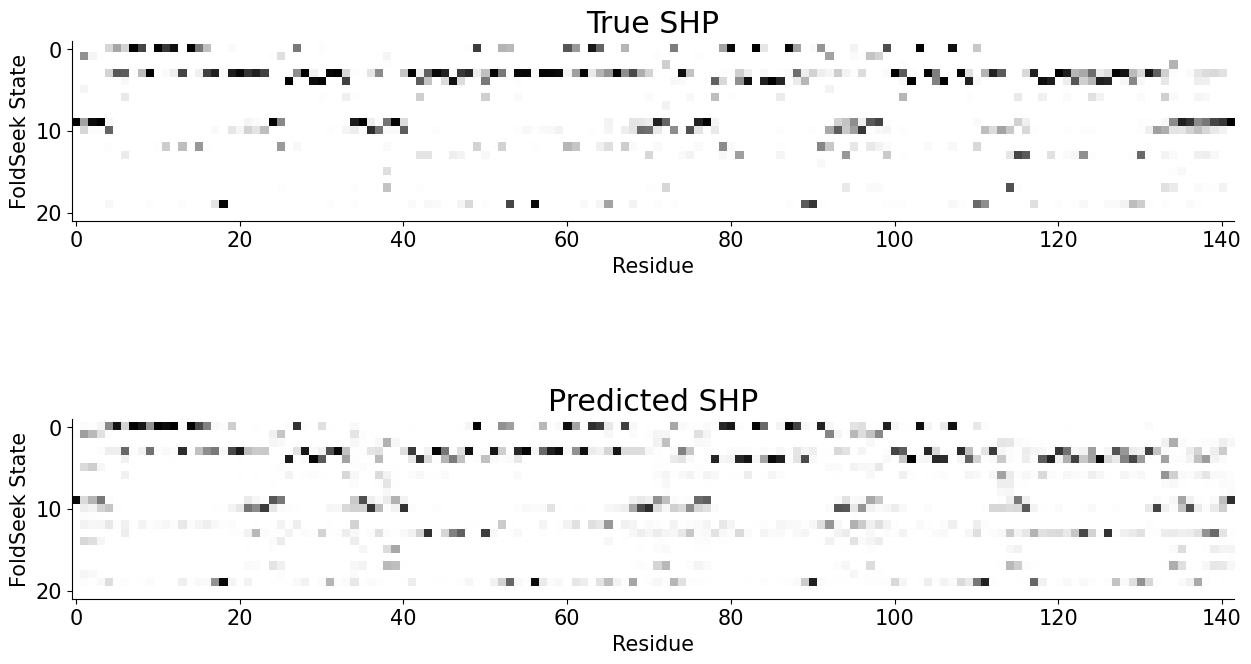

In [ ]:
# Foldseek Structure Heterogeneity Profile
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
from torch.nn.functional import softmax

true_shp = labels["shp"].squeeze().T
predicted_shp = both_result["shp"].cpu().squeeze().T

with plt.rc_context({"font.size": 18}):
    ax[0].imshow(true_shp, cmap="binary")
    ax[0].set_xlabel("True")
    ax[0].set_ylim(21, -1)
    ax[0].set_title("True SHP")
    ax[0].set_xlabel("Residue")
    ax[0].set_ylabel("FoldSeek State")

    ax[1].imshow(softmax(predicted_shp, dim=0), cmap="binary")
    # ax[1].imshow(predicted_shp, cmap="binary")
    ax[1].set_title("Predicted SHP")
    ax[1].set_ylabel("FoldSeek State")
    ax[1].set_xlabel("Residue")
    ax[1].set_ylim(21, -1)

    plt.savefig(
        config.FIGURES_DIR / f"{pdb_code_save}_shp_comparison.svg",
        bbox_inches="tight",
    )
plt.show()

1.7737343 -inf tensor(1.7741)


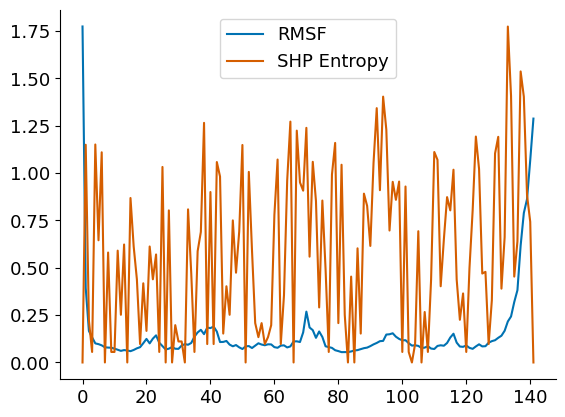

In [60]:
from scipy.stats import entropy

ent = entropy(true_shp)
p_ent = entropy(predicted_shp)
print(ent.max(), p_ent.max(), labels["rmsf"].max())
plt.plot(labels["rmsf"], label="RMSF")
plt.plot(ent, label="SHP Entropy")
# plt.plot(p_ent, label="Predicted SHP Entropy")
plt.legend()
plt.show()

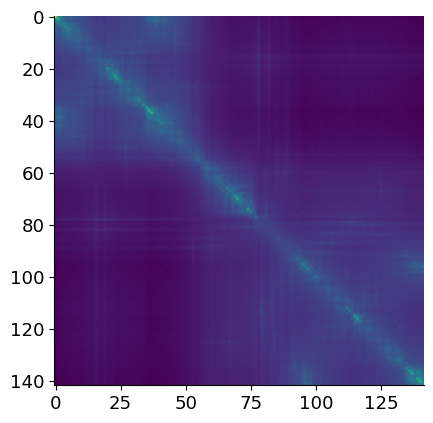

In [61]:
GNM_ROOT = (
    "/mnt/home/ssledzieski/Projects/rocketshp/data/processed/atlas/gaussian_net_models"
)
gnm_covar = f"{GNM_ROOT}/{pdb_code[:2]}/{pdb_code}_gnm.npz"
gnm_data = np.load(gnm_covar)
gnm_covar = gnm_data["covar"]
plt.imshow(gnm_covar)
plt.show()

---

In [58]:
import glob

import torch

shp_files = glob.glob(f"{config.PROCESSED_DATA_DIR}/atlas/shp/*/*.pt")

In [59]:
results = []
for f in tqdm(shp_files):
    shp = torch.load(f)
    shp["shp"] = shp["shp"].squeeze()
    results.append(shp)


def invert_dict(l):
    """
    Convert from list of dicts to dict of lists, where the key is the joined "pdb_code" and "rep" keys of the inner dictionary
    """
    out_dict = {}
    keys = l[0].keys()
    for key in keys:
        out_dict[key] = [i[key] for i in l]
    return out_dict


shp = invert_dict(results)

  0%|          | 0/439 [00:00<?, ?it/s]/tmp/ipykernel_851609/1636531811.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shp = torch.load(f)
100%|██████████| 439/439 [00:

In [28]:
from datasets import Dataset

ds = Dataset.from_dict(shp)

In [97]:
import warnings

import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS


def distance_matrix_to_structure(distance_matrix, max_iter=1000, n_init=4):
    """
    Convert a distance matrix of Calpha positions into 3D coordinates.

    Parameters:
    -----------
    distance_matrix : numpy.ndarray
        Square matrix of pairwise distances between Calpha atoms
    max_iter : int, optional
        Maximum number of iterations for MDS optimization
    n_init : int, optional
        Number of times to run MDS with different random seeds

    Returns:
    --------
    coordinates : numpy.ndarray
        Nx3 array of predicted 3D coordinates for each Calpha
    stress : float
        Final stress value indicating quality of the embedding
    """
    # Input validation
    if not isinstance(distance_matrix, np.ndarray):
        distance_matrix = np.array(distance_matrix)

    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("Distance matrix must be square")

    # Ensure matrix is symmetric
    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    # Create MDS object
    mds = MDS(
        n_components=3,
        metric=True,
        max_iter=max_iter,
        n_init=n_init,
        dissimilarity="precomputed",
        normalized_stress="auto",
    )

    # Suppress convergence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Convert distance matrix to 3D coordinates
        try:
            coords = mds.fit_transform(distance_matrix)
            stress = mds.stress_
        except Exception as e:
            raise RuntimeError(f"MDS failed to converge: {str(e)}")

    return coords, stress


def save_to_pdb(coordinates, filename, resid, chain_id="A"):
    """
    Save the predicted coordinates to a PDB file format.

    Parameters:
    -----------
    coordinates : numpy.ndarray
        Nx3 array of 3D coordinates
    filename : str
        Output PDB filename
    chain_id : str, optional
        Chain identifier for the PDB file
    """
    with open(filename, "w") as f:
        f.write("TITLE     Predicted structure from distance matrix\n")
        for i, (coord, rid) in enumerate(zip(coordinates, resid)):
            x, y, z = coord
            # Standard PDB ATOM record format
            atom_line = (
                f"ATOM  {i + 1:5d}  CA  {rid} {chain_id}{i + 1:4d}"
                f"    {x:8.3f}{y:8.3f}{z:8.3f}"
                f"  1.00  0.00           C  \n"
            )
            f.write(atom_line)
        f.write("END\n")


def assess_structure_quality(distance_matrix, predicted_coords):
    """
    Assess the quality of the predicted structure by comparing
    the input and reconstructed distance matrices.

    Parameters:
    -----------
    distance_matrix : numpy.ndarray
        Original input distance matrix
    predicted_coords : numpy.ndarray
        Predicted 3D coordinates

    Returns:
    --------
    rmsd : float
        Root mean square deviation between original and
        reconstructed distances
    max_error : float
        Maximum error in any pairwise distance
    """
    # Calculate pairwise distances from predicted coordinates
    predicted_distances = squareform(pdist(predicted_coords))

    # Calculate errors
    errors = np.abs(distance_matrix - predicted_distances)
    rmsd = np.sqrt(np.mean(errors**2))
    max_error = np.max(errors)

    return rmsd, max_error

In [45]:
# Example distance matrix (you would replace this with your actual data)
n_residues = 10
# example_distances = np.random.uniform(3.8, 15.0, size=(n_residues, n_residues))
# example_distances = (example_distances + example_distances.T) / 2
# np.fill_diagonal(example_distances, 0)

# Convert to 3D coordinates
coords, stress = distance_matrix_to_structure(both_result["dyn_corr"].squeeze().numpy())

# Assess quality
# rmsd, max_error = assess_structure_quality(true_sqform.squeeze(), coords)

# print(f"Structure generated with stress: {stress:.4f}")
# print(f"RMSD from original distances: {rmsd:.4f} Å")
# print(f"Maximum pairwise distance error: {max_error:.4f} Å")

# Save to PDB file
save_to_pdb(coords, "predicted_structure.pdb", ["ALA"] * n_residues)

In [51]:
coords.shape

(183, 3)

In [53]:
adl.dataset._handle[key]["xyz"][:][0]

array([[ 2.0129595 ,  0.25868416,  2.0152874 ],
       [ 2.0029597 ,  0.21888423,  2.1108875 ],
       [ 1.9979596 ,  0.18248415,  1.9460874 ],
       ...,
       [-1.4010403 , -3.0623157 ,  0.33728743],
       [-1.3210402 , -3.1163158 ,  0.41828752],
       [-1.4220402 , -3.1123157 ,  0.22728753]], dtype=float32)

## Test Runtime

In [7]:
all_pdb_chains = adl.dataset._get_keys()

In [8]:
from rocketshp.esm3 import (
    _get_model,
    _get_structure_vae,
    _get_tokenizers,
    embed,
)

device = torch.device("cuda:0")

struct_encoder, _ = _get_structure_vae()
struct_encoder = struct_encoder.eval().to(device)

esm_model = _get_model("esm3-open")
esm_model = esm_model.eval().to(device)

tokenizers = _get_tokenizers("esm3-open")
struct_tokenizer = tokenizers.structure

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/pretrained.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/ssled

In [9]:
model = model.to(device)

In [10]:
[f.shape for f in feats.values()]

[torch.Size([183, 1536]), torch.Size([183]), torch.Size([183])]

In [11]:
import time

from esm.utils.encoding import tokenize_structure
from esm.utils.structure.protein_chain import ProteinChain

results = {}
precomputed_feats = {}

for pdb_id in tqdm(all_pdb_chains):
    pdb_file_path = config.RAW_DATA_DIR / f"atlas/{pdb_id[:2]}/{pdb_id}.pdb"
    esm_chain = ProteinChain.from_pdb(pdb_file_path)

    # Tokenize structure
    with torch.inference_mode():
        _, plddt, struct_tokens = tokenize_structure(
            torch.from_numpy(esm_chain.atom37_positions),
            structure_encoder=struct_encoder,
            structure_tokenizer=struct_tokenizer,
            reference_sequence=esm_chain.sequence,
        )

        # Embed sequence
        embeddings = embed(
            [esm_chain.sequence], esm_model, tokenizers, device=device
        ).squeeze()

        tmp_feats = {
            "seq_feats": embeddings.to("cpu"),
            "struct_feats": struct_tokens.to("cpu"),
            "temp": torch.tensor(300 * torch.ones_like(struct_tokens)).to("cpu"),
        }
        precomputed_feats[pdb_id] = tmp_feats

  0%|          | 0/1389 [00:00<?, ?it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
/tmp/ipykernel_555188/1647324440.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "temp": torch.tensor(300 * torch.ones_like(struct_tokens)).to("cpu")
  0%|          | 1/1389 [00:00<07:46,  2.98it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
100%|██████

In [31]:
from esm.utils.encoding import tokenize_structure
from esm.utils.structure.protein_chain import ProteinChain

results = {}

start_time = time.time()
for pdb_id in tqdm(all_pdb_chains):
    pdb_file_path = config.RAW_DATA_DIR / f"atlas/{pdb_id[:2]}/{pdb_id}.pdb"
    esm_chain = ProteinChain.from_pdb(pdb_file_path)

    # Tokenize structure
    with torch.inference_mode():
        _, plddt, struct_tokens = tokenize_structure(
            torch.from_numpy(esm_chain.atom37_positions),
            structure_encoder=struct_encoder,
            structure_tokenizer=struct_tokenizer,
            reference_sequence=esm_chain.sequence,
        )

        # Embed sequence
        embeddings = embed(
            [esm_chain.sequence], esm_model, tokenizers, device=device
        ).squeeze()

        tmp_feats = {
            "seq_feats": embeddings,
            "struct_feats": struct_tokens,
            "temp": torch.tensor(300 * torch.ones_like(struct_tokens)),
        }
        both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})

        results[pdb_id] = both_result

end_time = time.time()
logger.info(f"Time elapsed: {end_time - start_time:.2f} s")
logger.info(f"Time per sample: {(end_time - start_time) / len(all_pdb_chains):.2f} s")

  0%|          | 0/1389 [00:00<?, ?it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
/tmp/ipykernel_553152/3021995347.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "temp": torch.tensor(300 * torch.ones_like(struct_tokens))
100%|██████████| 1389/1389 [03:35<00:00,  6.46it/s]

2025-01-14 15:35:43.302 | INFO     | __main__:<module>:34 - Time elapsed: 215.14 s
2025-01-14 15:35:43.302 | INFO     | __main__:<module>:35 - Time per sample: 0.15 s
